In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
_2019 = pd.read_csv('data/IMDB_mine_data_2019.csv')
_2018 = pd.read_csv('data/IMDB_mine_data_2018.csv')
_2017 = pd.read_csv('data/IMDB_mine_data_2017.csv')
_2016 = pd.read_csv('data/IMDB_mine_data_2016.csv')
_2015 = pd.read_csv('data/IMDB_mine_data_2015.csv')

In [3]:
#get all the films into one DF
films = pd.concat([_2019,_2018,_2017,_2016,_2015])

In [4]:
# remove the filler films we were using to start the mining bot
films = films[films['title_code'] != np.nan]
films = films[films['release_date'] != '1980-05-16']
films.shape

(2965, 27)

In [5]:
#films.release_date
print(_2019.shape, _2018.shape, _2017.shape, _2016.shape, _2015.shape)

(482, 27) (683, 27) (675, 27) (609, 27) (520, 27)


In [6]:
films.head(2000)

,Unnamed: 0,title,runtime,release_date,rating,prod_co,metaScore,metaUserScore,imdb_rating,genre,actor1,actor2,actor3,actor4,actor5,actor6,actor7,actor8,actor9,actor10,directors,writers,budget,opening_wknd,gross_dom,gross_int,title_code
1,0,Motherless Brooklyn,0,2019-11-01,R,"['Class 5 Films', 'Warner Bros.']",0,0,0,"['Crime', 'Drama', 'Mystery']",/name/nm0001570/,/name/nm1813221/,/name/nm0000285/,/name/nm0134072/,/name/nm0000353/,/name/nm0000246/,/name/nm0839486/,/name/nm0427728/,/name/nm1316767/,/name/nm0656929/,['Edward Norton'],"['Jonathan Lethem', 'Edward Norton']",26000000.0,3500454.0,9277736.0,1.847774e+07,tt0385887
2,0,Alita: Battle Angel,0,2019-02-14,PG-13,"['Twentieth Century Fox', 'Twentieth Century F...",0,0,0,"['Action', 'Adventure', 'Sci-Fi', 'Thriller']",/name/nm4023073/,/name/nm0910607/,/name/nm0000124/,/name/nm0991810/,/name/nm4534098/,/name/nm0355097/,/name/nm5277107/,/name/nm7449863/,/name/nm7093076/,/name/nm1701107/,['Robert Rodriguez'],"['James Cameron', 'Laeta Kalogridis', 'Yukito ...",170000000.0,28525613.0,85710210.0,4.048525e+08,tt0437086
3,0,Danger Close,0,2019-11-08,R,"['Deeper Water', 'Saboteur Media', 'Saban Films']",0,0,0,"['Action', 'Drama', 'War']",/name/nm1379938/,/name/nm9826817/,/name/nm1542397/,/name/nm2527406/,/name/nm5937328/,/name/nm9680111/,/name/nm3478396/,/name/nm7011217/,/name/nm2828232/,/name/nm7202582/,['Kriv Stenders'],"['Stuart Beattie', 'James Nicholas', 'Karel Se...",35000000.0,2078370.0,NaN,NaN,tt0441881
4,0,Shazam!,0,2019-04-05,PG-13,"['Warner Bros.', 'Warner Bros.']",0,0,0,"['Action', 'Adventure', 'Comedy', 'Fantasy']",/name/nm1157048/,/name/nm0835016/,/name/nm4755508/,/name/nm6244013/,/name/nm0111013/,/name/nm0005023/,/name/nm7968936/,/name/nm0328709/,/name/nm1534201/,/name/nm1218924/,['David F. Sandberg'],"['Henry Gayden', 'Henry Gayden', 'Darren Lemke...",100000000.0,53505326.0,140371656.0,3.659717e+08,tt0448115
5,0,The Last Full Measure,0,2020-01-24,R,"['Foresight Unlimited', 'Foresight Unlimited',...",0,0,0,"['Drama', 'War']",/name/nm1659221/,/name/nm0837223/,/name/nm8313926/,/name/nm0004986/,/name/nm0925966/,/name/nm0000458/,/name/nm0730070/,/name/nm3528539/,/name/nm5478558/,/name/nm0001626/,['Todd Robinson'],['Todd Robinson'],20000000.0,1058019.0,2949212.0,3.006059e+06,tt0783640
6,0,Pet Sematary,0,2019-04-05,R,"['Paramount Pictures', 'Paramount Pictures']",0,0,0,"['Horror', 'Mystery', 'Thriller']",/name/nm0164809/,/name/nm1541272/,/name/nm0001475/,/name/nm5503448/,/name/nm9923811/,/name/nm9923812/,/name/nm7744278/,/name/nm10055599/,/name/nm0004265/,/name/nm0774891/,"['Kevin Kölsch', 'Dennis Widmyer']","['Stephen King', 'Matt Greenberg', 'Jeff Buhler']",21000000.0,24502775.0,54724696.0,1.131182e+08,tt0837563
7,0,Fiddler: A Miracle of Miracles,0,2019-11-05,PG-13,['Roadside Attractions'],0,0,0,['Documentary'],/name/nm11046471/,/name/nm2744631/,/name/nm0090656/,/name/nm1388685/,/name/nm0149446/,/name/nm1753386/,/name/nm11046472/,/name/nm4842375/,/name/nm0001213/,/name/nm0001297/,['Max Lewkowicz'],"['Max Lewkowicz', 'Valerie Thomas']",36425.0,549386.0,558816.0,NaN,tt10003978
8,0,Linda Ronstadt: The Sound of My Voice,0,2019-09-06,PG-13,"['CNN Films', 'CNN']",0,0,0,"['Documentary', 'Biography', 'Music']",/name/nm0740168/,/name/nm0707248/,/name/nm0000573/,/name/nm0004994/,/name/nm0115010/,/name/nm1601015/,/name/nm0377118/,/name/nm0311691/,/name/nm0001081/,/name/nm0005270/,"['Rob Epstein', 'Jeffrey Friedman']",[],113235.0,4252657.0,4252657.0,NaN,tt10011448
9,0,P Storm,0,2019-04-04,Not Rated,"['Mandarin Motion Pictures', 'Well Go USA Ente...",0,0,0,"['Action', 'Crime']",/name/nm0465503/,/name/nm0155588/,/name/nm1332451/,/name/nm0482628/,/name/nm3012172/,/name/nm0848377/,/name/nm0156492/,/name/nm0514961/,/name/nm0516327/,/name/nm1319395/,['David Lam'],"['Man-Lung Ho', 'Ho-Wah Wong']",104071.0,326711.0,117991727.0,NaN,tt10017680
10,0,Between Me and My Mind,0,2019-04-27,NaN,"['Believe Entertainment Group', 'Paradigm Tale...",0,0,0,['Documentary'],/name/nm10651990/,/name/nm10651991/,

In [7]:
#Reset the index now that all films are in 1 dataframe
films = films.reset_index(drop=True)

# Cleaning fields and filling in some of the columns

In [8]:
re.findall(r"'(.*?)'",films.prod_co[0], re.DOTALL)

['Class 5 Films', 'Warner Bros.']

In [9]:
films.prod_co = films.prod_co.map(lambda x : re.findall(r"'(.*?)'",x, re.DOTALL))
films.prod_co[5]

['Paramount Pictures', 'Paramount Pictures']

In [10]:
films.prod_co[1][1]

'Twentieth Century Fox'

In [11]:
#break production and distribution out into their own columns
films['production'] = films['prod_co'].map(lambda x : x[0] if len(x) >= 1 else np.nan)
films['production_2'] = films['prod_co'].map(lambda x : x[1] if len(x) >= 3 else np.nan)
films['distribution'] = films['prod_co'].map(lambda x : x[-1] if len(x) >= 2 else np.nan)

In [12]:
#convert the release date to a pandas datetime object
films['release_date'] = films['release_date'].map(lambda x : pd.to_datetime(x))

In [13]:
#Set the first director to their own column
films.directors = films.directors.map(lambda x : re.findall(r"'(.*?)'",x, re.DOTALL if isinstance(x, str) else np.nan))
films['director'] = films['directors'].map(lambda x: x[0] if len(x) >= 1 else np.nan)

In [14]:
print("The highest grossing film made: $"+str(films['opening_wknd'].max()))
print("The lowest grossing film made: $"+str(films['opening_wknd'].min()))
print("The variance in opening weekend is: $"+str(films['opening_wknd'].var()))
print("The average opening weekend is: $"+str(round(films['opening_wknd'].mean())))

The highest grossing film made: $357115007.0
The lowest grossing film made: $108.0
The variance in opening weekend is: $449801058804183.4
The average opening weekend is: $6284064.0


[Text(0, 0, ''),
 Text(0, 0, '$50M'),
 Text(0, 0, '$100M'),
 Text(0, 0, '$150M'),
 Text(0, 0, '$200M'),
 Text(0, 0, '$250M'),
 Text(0, 0, '$300M'),
 Text(0, 0, '$350M'),
 Text(0, 0, '$400M')]

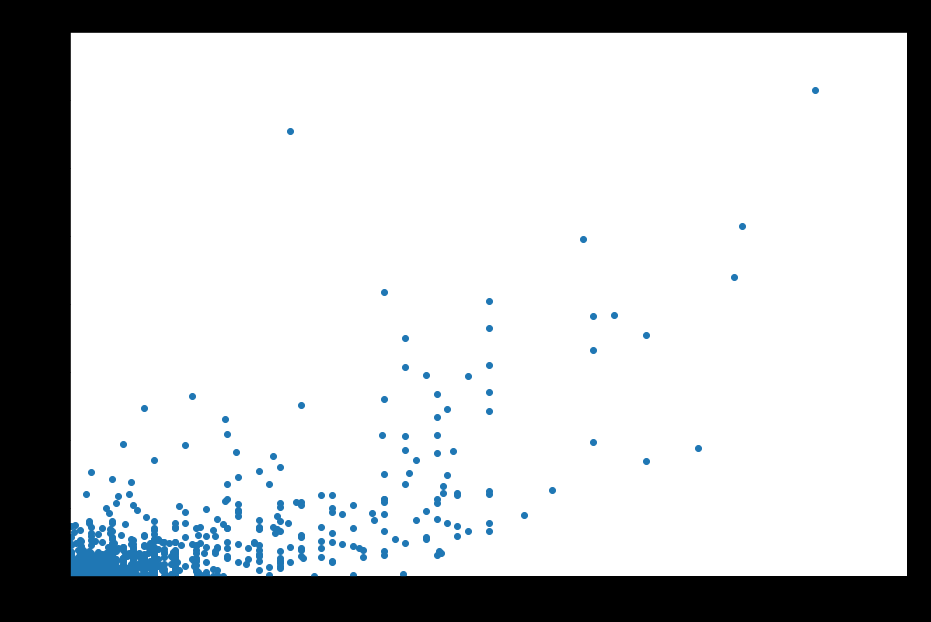

In [15]:
import locale
locale.setlocale( locale.LC_ALL, 'en_US' )

ylab = np.arange(0,401, 50)
xlab = np.arange(0,401, 50)

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(films.budget, films.opening_wknd)
ax.ticklabel_format(style='plain')
ax.set_ylabel('Opening Weekend Revenue', fontsize=18)
ax.set_xlabel('Film Budget', fontsize=18)
ax.set_title('Budget vs Opening Weekend (usd)', fontsize=24)
ax.grid(False)

fig.patch.set_facecolor('black')
plt.style.use('bmh')
#plt.rc('axes', labelsize=18)
plt.ylim(0, 400000000)
plt.xlim(0, 400000000)


labels = [item for item in ax.get_xticklabels()]
#print(labels)
ylabels = [item for item in ax.get_yticklabels()]
#print(ylabels)
for i in range(len(labels)):
    if i==0:
        labels[i] = ''
        continue
    labels[i] = "${}M".format(xlab[i])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)



#plt.savefig('img/Budget.v.BoxOffice2.png')

(0, 1010000)

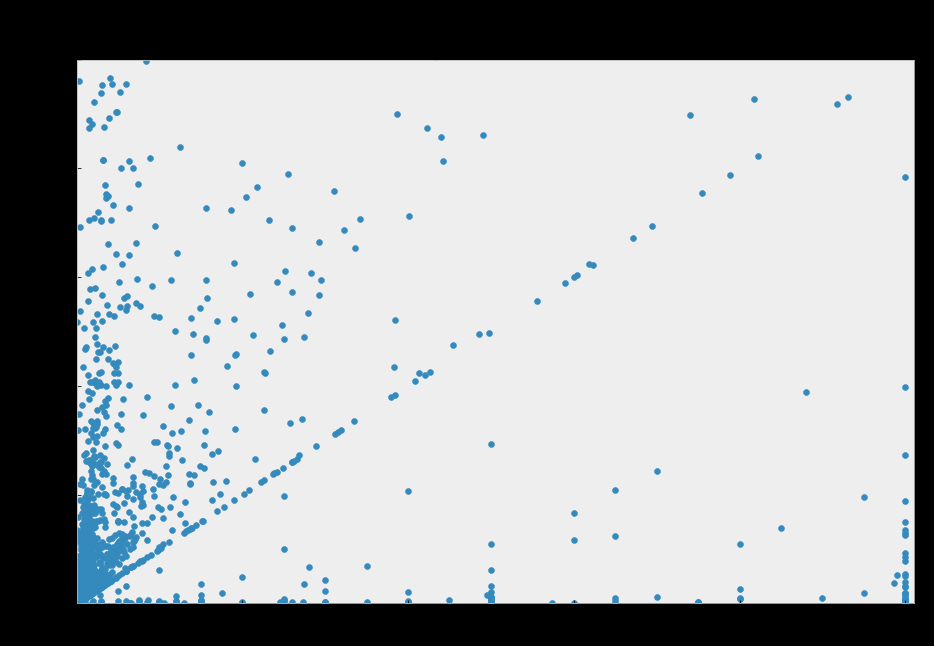

In [16]:
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(films.budget, films.opening_wknd)
ax.ticklabel_format(style='plain')
ax.set_ylabel('Opening Weekend Revenue', fontsize=18)
ax.set_xlabel('Film Budget', fontsize=18)
ax.set_title('Budget vs Opening Weekend (usd)\nless than $1M', fontsize=24)
ax.grid(False)

fig.patch.set_facecolor('black')
plt.style.use('bmh')
#plt.rc('axes', labelsize=18)
plt.ylim(0, 1000000)
plt.xlim(0, 1010000)




#plt.savefig('img/Budget.v.BoxOffice-OHNO2.png')

[Text(0, 0, ''),
 Text(0, 0, '$0'),
 Text(0, 0, '$50M'),
 Text(0, 0, '$100M'),
 Text(0, 0, '$150M'),
 Text(0, 0, '$200M'),
 Text(0, 0, '$250M'),
 Text(0, 0, '$300M'),
 Text(0, 0, '$350M'),
 Text(0, 0, '$400M')]

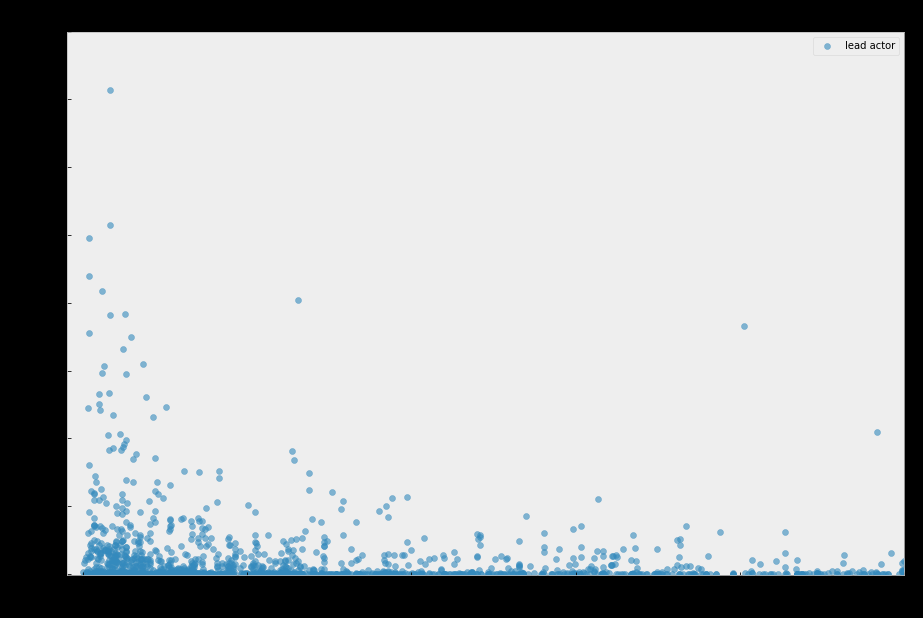

In [24]:
fig, ax = plt.subplots(figsize=(15,10))


ax.scatter(films.actor1_popularity, films.opening_wknd, alpha=0.6, label='lead actor')
#ax.scatter(films.actor2_popularity, films.opening_wknd, alpha=0.4, c='red', label='2nd billed')
#ax.scatter(films.actor3_popularity, films.opening_wknd, alpha=0.2, c='green', label='3rd billed')
#ax.scatter(films.actor4_popularity, films.opening_wknd, alpha=0.55, c='brown', label='4th billed')
#ax.scatter(films.actor5_popularity, films.opening_wknd, alpha=0.5, c='purple', label='5th billed')
#ax.scatter(films.actor6_popularity, films.opening_wknd, alpha=0.45, c='green', label='6th billed')
#ax.scatter(films.actor7_popularity, films.opening_wknd, alpha=0.4, c='yellow', label='7th billed')
#ax.scatter(films.actor8_popularity, films.opening_wknd, alpha=0.3, c='black', label='8th billed')
#ax.scatter(films.actor9_popularity, films.opening_wknd, alpha=0.2, c='brown', label='9th billed')
#ax.scatter(films.actor10_popularity, films.opening_wknd, alpha=0.1, c='coral', label='10th billed')
ax.ticklabel_format(style='plain')
ax.set_ylabel('Opening Weekend Revenue', fontsize=18)
ax.set_xlabel('IMDB Popularity Score', fontsize=18)
ax.set_title('Cast Popularity vs Opening Weekend', fontsize=24)
ax.grid(False)

fig.patch.set_facecolor('black')
plt.style.use('bmh')
#plt.rc('axes', labelsize=18)
plt.ylim(-1000000, 400000000)
plt.xlim(-100, 5000)
plt.legend()

l=plt.legend()
for text in l.get_texts():
    text.set_color('black')
    
ylab = ['','$0', '$50M', '$100M', '$150M', '$200M', '$250M', '$300M', '$350M', '$400M']
ax.set_yticklabels(ylab)

#plt.savefig('img/AllActorPop-v-OpeningWknd3.png')

In [25]:
# look at the revenue by month of release.
df = films.copy()
df.index = pd.to_datetime(df.release_date)
df['month'] = df.index.month
df['year'] = df.index.year
avg = df.groupby(pd.Grouper(freq='M')).sum()

7


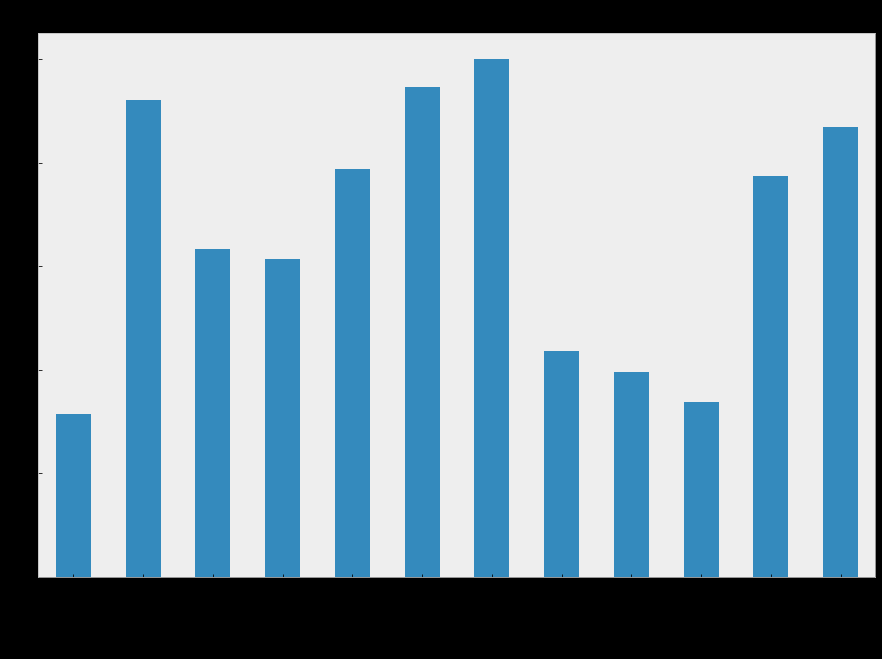

In [26]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ylab = ['$0', '$2M', '$4M', '$6M', '$8M', '$10M', '$12M']

fig, ax1 = plt.subplots(figsize=(15,10))

df.groupby('month').agg({'opening_wknd': 'mean'}).plot(figsize=(15,10), xlim=(1,2), grid=False, kind='bar', style='plain', legend=False, ax=ax1)
ax1.set_title('Average Opening Box Office of ALL Films by Month', fontsize=26)
fig.patch.set_facecolor('black')

labels = [item.get_text() for item in ax1.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = months[i]
ax1.set_xticklabels(labels)
#ax1.ticklabel_format(style='plain')

ylabels = [item.get_text() for item in ax1.get_yticklabels()]
for i in range(len(ylabels)):
    ylabels[i] = ylab[i]
ax1.set_yticklabels(ylabels)
print(len(ylabels))

#plt.tight_layout()
#plt.savefig('img/AvgBoxOffice_byMonth3.png')

IndexError: list index out of range

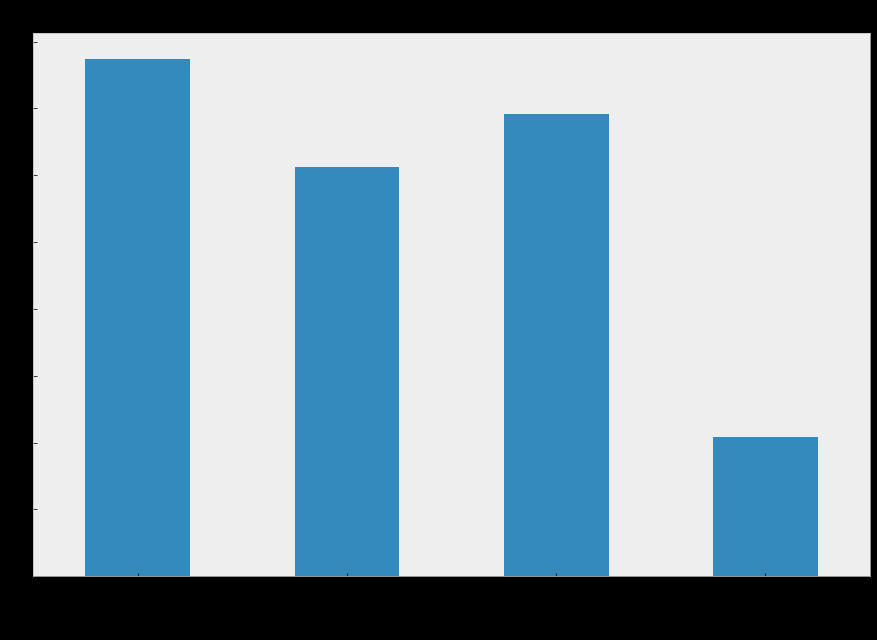

In [27]:
ylab = ['$0', '$5M', '$10M', '$15M', '$20M']
xlab = ['G', 'PG', 'PG-13', 'R']

fig, ax1 = plt.subplots(figsize=(15,10))

rate_df = df[df['rating'] != 'Approved']
rate_df = rate_df[rate_df['rating'] != 'Not Rated']
rate_df = rate_df[rate_df['rating'] != 'Unrated']
rate_df = rate_df[rate_df['rating'] != 'M']
rate_df = rate_df[rate_df['rating'] != 'TV-14']
rate_df = rate_df[rate_df['rating'] != 'TV-G']
rate_df = rate_df[rate_df['rating'] != 'NC-17']
rate_df = rate_df[rate_df['rating'] != 'TV-MA']
rate_df = rate_df[rate_df['rating'] != 'TV-PG']

rate_df.groupby('rating').agg({'opening_wknd': 'mean'}).plot(figsize=(15,10), grid=False, kind='bar', style='plain', legend=False, ax=ax1)
ax1.set_title('Average Opening Box Office by MPAA Rating', fontsize=26)
plt.style.use('bmh')
fig.patch.set_facecolor('black')
#ax1.set_ylabel('Average Opening Revenue', fontsize=20)
ax1.set_xlabel('MPAA Rating', fontsize=20)

ylabels = [item.get_text() for item in ax1.get_yticklabels()]
for i in range(len(ylabels)):
    ylabels[i] = ylab[i]
ax1.set_yticklabels(ylabels, fontsize=14)

labels = [item.get_text() for item in ax1.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = xlab[i]
ax1.set_xticklabels(labels, fontsize=16)

for tick in ax1.get_xticklabels():
    tick.set_rotation(0)

#plt.savefig('img/AvgBoxOffice_byRating3.png')

In [ ]:
action = films[films['action'] > 0]
adventure = films[films['adventure'] > 0]
animated = films[films['animated'] > 0]
biography = films[films['biography'] > 0]
drama = films[films['drama'] > 0]
documentary = films[films['documentary'] > 0]
comedy = films[films['comedy'] > 0]
crime = films[films['crime'] > 0]
fantasy = films[films['fantasy'] > 0]
family = films[films['family'] > 0]
musical = films[films['musical'] > 0]
horror = films[films['horror'] > 0]
war = films[films['war'] > 0]
mystery = films[films['mystery'] > 0]
sci_fi = films[films['sci-fi'] > 0]
thriller = films[films['thriller'] > 0]
romance = films[films['romance'] > 0]

In [ ]:
act_avg = action['opening_wknd'].mean()
adv_avg = adventure['opening_wknd'].mean()
anim_avg = animated['opening_wknd'].mean()
com_avg = comedy['opening_wknd'].mean()
crm_avg = crime['opening_wknd'].mean()
bio_avg = biography['opening_wknd'].mean()
dra_avg = drama['opening_wknd'].mean()
doc_avg = documentary['opening_wknd'].mean()
fan_avg = fantasy['opening_wknd'].mean()
fam_avg = family['opening_wknd'].mean()
mus_avg = musical['opening_wknd'].mean()
hor_avg = horror['opening_wknd'].mean()
war_avg = war['opening_wknd'].mean()
mys_avg = mystery['opening_wknd'].mean()
sci_avg = sci_fi['opening_wknd'].mean()
thr_avg = thriller['opening_wknd'].mean()
rom_avg = romance['opening_wknd'].mean()

In [ ]:
labs =['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Documentary', 'Fantasy', 
       'Family', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War']
vals = [act_avg, adv_avg, anim_avg, bio_avg, com_avg, crm_avg, dra_avg, doc_avg, fan_avg, fam_avg, hor_avg, mus_avg,
       mys_avg, rom_avg, sci_avg, thr_avg, war_avg]
ylab = ['$0', '$5M', '$10M', '$15M', '$20M', '$25M', '$30M']

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.bar(labs,vals)
fig.patch.set_facecolor('black')
#ax1.set_ylabel('Average Opening Revenue', fontsize=20)
ax1.set_xlabel('Average Opening by Genre', fontsize=20)
ax1.grid(False)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')

ylabels = [item.get_text() for item in ax1.get_yticklabels()]
for i in range(len(ylabels)):
    ylabels[i] = ylab[i]
ax1.set_yticklabels(ylabels, fontsize=14)

plt.savefig('img/AvgOpeningByGenre1.png')

In [ ]:
xlab = ['2015', '2016', '2017', '2018', '2019']
ylab = ['$0', '$5M', '$10M', '$15M', '$20M']

fig, ax1 = plt.subplots(figsize=(15,10))

df[df.index.year < 2020].groupby('year').agg({'opening_wknd': 'mean', 'budget':'mean'}).plot(figsize=(15,10), kind='bar', grid=False, ax=ax1)
ax1.set_title('Average Budget & Opening by Year', fontsize=26)
fig.patch.set_facecolor('black')
ax1.set_xlabel('Year', fontsize=20)

labels = [item.get_text() for item in ax1.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = xlab[i]
ax1.set_xticklabels(labels, fontsize=16)

for tick in ax1.get_xticklabels():
    tick.set_rotation(0)
    
ylabels = [item.get_text() for item in ax1.get_yticklabels()]
for i in range(len(ylabels)):
    ylabels[i] = ylab[i]
ax1.set_yticklabels(ylabels, fontsize=14)

l=plt.legend()
l.get_texts()[0].set_text('Opening Weekend')
l.get_texts()[1].set_text('Budget')
for text in l.get_texts():
    text.set_color('black')
    
plt.savefig('img/AvgBudget-OpeningByYear11.png')

# Looking at the actors now.

In [ ]:
from collections import defaultdict

def leaders(xs, top=21):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]

def tailers(xs, top=21):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=False, key=lambda tup: tup[1])[:top]

In [ ]:
all_actors = list(films.actor1) + list(films.actor2) + list(films.actor3) + list(films.actor4) + list(films.actor5) + list(films.actor6) + list(films.actor7) + list(films.actor8) + list(films.actor9) + list(films.actor10)
print(len(np.unique(all_actors)))
unique_actors = np.unique(all_actors)

In [ ]:
topActors = leaders(all_actors, top=20)[1:]
bottomActors = tailers(all_actors, top=20)
topActors

In [ ]:
# Exporting a csv for the actor popularity scraper to use.
#pd.Series(np.unique(list(films.actor1))[:-1]).to_csv('data/actor1_unique_list.csv')

In [ ]:
len(np.array(actor_key['actor']))
missing = []
def find_missing_keys(key):
    #print(key)
    if isinstance(key, float):
        return key
    if len(actor_key.loc[actor_key['0'] == key]) < 1:
        missing.append(key)
        print("appended "+key)
        return
    return 'cleared'

for k in all_actors:
    find_missing_keys(k)
    
print(missing)

In [ ]:
#pd.DataFrame(missing, columns=['actor']).to_csv('data/missing_actors.csv')

In [ ]:
len(missing)

In [ ]:
#generating a list of missing actor codes for the bot to go fetch for me
codes = [i[0] for i in topActors]
missing_codes =[]
gathered = np.array(actor_key['actor'])
for c in unique_actors:
    if c not in gathered:
        missing_codes.append(c)

print(len(missing_codes))
fetch_df = pd.DataFrame(unique_actors, columns=['actor'])
#fetch_df.to_csv('data/actor_popularity_fetch_list.csv')
fetch_df.info()

In [ ]:
a_keys = [i[0] for i in topActors]
b_keys = [i[0] for i in bottomActors]
a_keys
b_keys

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
plt.bar(*zip(*topActors))
plt.xticks(rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.ylim(10,17)
plt.xticks(fontsize=15)

ax.set_ylabel('Number of films', fontsize=20)
ax.set_xlabel('Actor', fontsize=20)
ax.set_title('20 Most Film Credits by Actor (2015-2019)', fontsize=24)
fig.patch.set_facecolor('black')
ax.grid(False)

labels = get_actor_names(a_keys)
ax.set_xticklabels(labels)

plt.tight_layout()
#plt.savefig('img/FilmCountByActor4.png')

In [ ]:
#going back to pull all the title codes to send director bot to fetch director popularity
#films['title_code'].to_csv('data/director_popularity_scrape_list.csv')

In [ ]:
actor_key = pd.read_csv('data/actor_key.csv', index_col=0).reset_index(drop=True)
#actor_key = pd.read_csv('data/2019_actors_out.csv', index_col=0).append(missing_df).reset_index() #<--- This is a dirty hack to push a missing actor into the DF
actor_key.shape
actor_key.head()

In [ ]:
row = actor_key.loc[actor_key['actor'] == '/name/nm0136797/'].index[0] #/name/nm0000168/
print(row)
actor_key.iloc[row]['name']

In [ ]:
def get_actor_names(keys):
    r = []
    for k in keys:
        r.append(get_actor_name(k))
    return r

def get_actor_name(key):
    #print(key)
    row = actor_key.loc[actor_key['actor'] == key].index[0]
    return(actor_key.iloc[row]['name'])

def get_actor_key(name):
    #print(key)
    row = actor_key.loc[actor_key['name'] == name].index[0]
    return(actor_key.iloc[row]['actor'])

## Adding Popularity Column

In [19]:
act1_pop_keys = pd.read_csv('data/actor1_popularity_out.csv', index_col=0)
act1_pop_keys.reset_index(inplace=True)
act1_pop_keys.head()

,index,actor,popularity
0,0,/name/nm0000005/,2932
1,0,/name/nm0000006/,2565
2,0,/name/nm0000008/,412
3,0,/name/nm0000093/,48
4,0,/name/nm0000095/,793


In [20]:
dir_pop_keys = pd.read_csv('data/director_popularity_manipulated.csv', index_col=0)
dir_pop_keys.reset_index(inplace=True)
dir_pop_keys.head()

act_pop_keys = pd.read_csv('data/actor_popularity_out.csv', index_col=0)
act_pop_keys.reset_index(inplace=True, drop=True)
act_pop_keys.head()

,actor,popularity
0,/name/nm0000002/,2519
1,/name/nm0000004/,5460
2,/name/nm0000005/,2932
3,/name/nm0000006/,2565
4,/name/nm0000008/,412


In [21]:
fake_popularity = 10071118 #instantiated as the lowest actor popularity +1
def get_actor1_popularity(code, fake_pop):
    if code in act1_pop_keys['actor'].unique():
        row = act1_pop_keys.loc[act1_pop_keys['actor'] == code].index[0]
        return act1_pop_keys.iloc[row]['popularity']
    else:
        return fake_pop + randint(0,1000)

def get_dir_pop(code, fake_pop):
    if code in dir_pop_keys['name'].unique():
        row = dir_pop_keys.loc[dir_pop_keys['name'] == code].index[0]
        return dir_pop_keys.iloc[row]['popularity']
    else:
        return fake_pop + randint(0,1000)
    
def get_act_pop(code, fake_pop):
    if code in act_pop_keys['actor'].unique():
        row = act_pop_keys.loc[act_pop_keys['actor'] == code].index[0]
        return act_pop_keys.iloc[row]['popularity']
    else:
        return fake_pop + randint(0,1000)

In [22]:
get_actor1_popularity('/name/nm003565/', fake_popularity)
get_dir_pop('David F. Sandberg', fake_popularity)

13408

In [23]:
films['actor1_popularity'] = films['actor1'].map(lambda x : get_actor1_popularity(x,fake_popularity))
films['actor2_popularity'] = films['actor2'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor3_popularity'] = films['actor3'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor4_popularity'] = films['actor4'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor5_popularity'] = films['actor5'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor6_popularity'] = films['actor6'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor7_popularity'] = films['actor7'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor8_popularity'] = films['actor8'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor9_popularity'] = films['actor9'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor10_popularity'] = films['actor10'].map(lambda x : get_act_pop(x,fake_popularity))


films['director_popularity'] = films['director'].map(lambda x : get_dir_pop(x,fake_popularity))

### converting popularity scores into letter-list of actor for one-hot encoding

In [ ]:
def get_celeb_class(pop):
    if pop <=2000:
        return 'A-list'
    elif pop <= 5000:
        return 'B-list'
    elif pop <= 20000:
        return 'C-list'
    elif pop <= 100000:
        return 'D-list'
    elif pop <= 250000:
        return 'E-list'
    else:
        return 'nobody'

In [ ]:
films['actor1_class'] = films['actor1_popularity'].map(lambda x : get_celeb_class(x))
films['actor2_class'] = films['actor2_popularity'].map(lambda x : get_celeb_class(x))
films['actor3_class'] = films['actor3_popularity'].map(lambda x : get_celeb_class(x))
films['actor4_class'] = films['actor4_popularity'].map(lambda x : get_celeb_class(x))
films['actor5_class'] = films['actor5_popularity'].map(lambda x : get_celeb_class(x))
films['actor6_class'] = films['actor6_popularity'].map(lambda x : get_celeb_class(x))
films['actor7_class'] = films['actor7_popularity'].map(lambda x : get_celeb_class(x))
films['actor8_class'] = films['actor8_popularity'].map(lambda x : get_celeb_class(x))
films['actor9_class'] = films['actor9_popularity'].map(lambda x : get_celeb_class(x))
films['actor10_class'] = films['actor10_popularity'].map(lambda x : get_celeb_class(x))

# Using the work I just did on the actors to generate a filter for the actor columns in the main DF

In [ ]:
keepActors = leaders(all_actors, top=250)[1:]
k_keys = [i[0] for i in keepActors]
get_actor_names(k_keys)

In [ ]:
keep_df = pd.DataFrame(columns=['actor', 'name'])
print(len(k_keys))
keep_df['actor'] = k_keys
keep_df['name'] = get_actor_names(k_keys)
#keep_df.to_csv('data/actor_filter.csv')
keep_df.head()

In [ ]:
act_filter = pd.read_csv('data/actor_filter.csv', index_col=0)

In [ ]:
def actor_filter(a_code):
    if a_code in act_filter['actor'].unique():
        return get_actor_name(a_code)
    else:
        return "unknown"

In [ ]:
pd.set_option('max_columns', None)
#films = films[films['budget'] > 0]
print(films.shape)
films.head()

In [ ]:
films['actor_1'] = films['actor1'].map(lambda x : actor_filter(x))
films['actor_2'] = films['actor2'].map(lambda x : actor_filter(x))
films['actor_3'] = films['actor3'].map(lambda x : actor_filter(x))
films['actor_4'] = films['actor4'].map(lambda x : actor_filter(x))
films['actor_5'] = films['actor5'].map(lambda x : actor_filter(x))
films['actor_6'] = films['actor6'].map(lambda x : actor_filter(x))
films['actor_7'] = films['actor7'].map(lambda x : actor_filter(x))
films['actor_8'] = films['actor8'].map(lambda x : actor_filter(x))
films['actor_9'] = films['actor9'].map(lambda x : actor_filter(x))
films['actor_10'] = films['actor10'].map(lambda x : actor_filter(x))

# Normalize the budget data

In [ ]:
bud = films[['budget']].values
min_max_scaler = preprocessing.MinMaxScaler()
bud_scaled = min_max_scaler.fit_transform(bud)
films['budget_normalized']=bud_scaled

# Change the timestamp into months and years

In [ ]:
#films = films[films['release_month'] != np.nan] #git rid of entires without release dates
films['release_month'] = films['release_date'].map(lambda x : pd.to_datetime(x).month)
films['release_month'] = films['release_month'].map(lambda x : 'January' if x == 1 else ( 'February' if x==2 else ( 'March' if x==3 else ( 'April' if x==4 else ('May' if x==5 else ('June' if x==6 else ( 'July' if x==7 else ( 'August' if x==8 else ('September' if x==9 else ( 'October' if x==10 else ( 'November' if x==11 else ('December' if x==12 else 'unknown'))))))))) ) ))

In [ ]:
films['release_year'] = films['release_date'].map(lambda x : x.year)
films['release_year'] = films['release_year'].map(lambda x : '2015' if x == 2015 else ( '2016' if x==2016 else ( '2017' if x==2017 else ( '2018' if x==2018 else ('2019' if x==2019 else ('2020' if x==2020 else 'none'))))))

# Next we need to filter directors

In [ ]:
#push out a csv that we will use to filter
#pd.Series(films['director'].unique()).to_csv('data/director_list.csv')

In [ ]:
#pull in the cut down list
dir_filter = pd.read_csv('data/director_filter.csv', index_col=0)
dir_filter.head()

In [ ]:
def director_filter(name):
    if name in dir_filter['director'].unique():
        return name
    else:
        return "unknown"

In [ ]:
films['known_director'] = films['director'].map(lambda x : director_filter(x))

# Next we will filter Production/Distribution companies

In [ ]:
#create a unique list of ALL the companies in the df
#pd.Series(films['production'].append(films['distribution']).unique()).to_csv('data/company_list.csv')

In [ ]:
co_filter = pd.read_csv('data/company_filter.csv', index_col=0)
co_filter.head()

In [ ]:
def company_filter(name):
    if name in co_filter['company'].unique():
        return name
    else:
        return "unknown"

In [ ]:
films['known_production_1'] = films['production'].map(lambda x : company_filter(x))
films['known_production_2'] = films['production_2'].map(lambda x : company_filter(x))
films['known_distribution'] = films['distribution'].map(lambda x : company_filter(x))

# Finally We need to one-hot for genre

In [ ]:
# we need to extract the inner quotes from the strings into a list.
films['genre'] = films['genre'].map(lambda x : re.findall(r"'(.*?)'",x, re.DOTALL))

In [ ]:
#we're going to do the OHE manually
films['action'] = films['genre'].map(lambda x : 1 if 'Action' in x else 0)
films['adventure']  = films['genre'].map(lambda x : 1 if 'Adventure' in x else 0)
films['animated'] = films['genre'].map(lambda x : 1 if 'Animation' in x else 0)
films['biography'] = films['genre'].map(lambda x : 1 if 'Biography' in x else 0)
films['drama'] = films['genre'].map(lambda x : 1 if 'Drama' in x else 0)
films['documentary'] = films['genre'].map(lambda x : 1 if 'Documentary' in x else 0)
films['comedy'] = films['genre'].map(lambda x : 1 if 'Comedy' in x else 0)
films['crime'] = films['genre'].map(lambda x : 1 if 'Crime' in x else 0)
films['fantasy'] = films['genre'].map(lambda x : 1 if 'Fantasy' in x else 0)
films['family'] = films['genre'].map(lambda x : 1 if 'Family' in x else 0)
films['musical'] = films['genre'].map(lambda x : 1 if 'Musical' in x else 0)
films['horror'] = films['genre'].map(lambda x : 1 if 'Horror' in x else 0)
films['war'] = films['genre'].map(lambda x : 1 if 'War' in x else 0)
films['mystery'] = films['genre'].map(lambda x : 1 if 'Mystery' in x else 0)
films['sci-fi'] = films['genre'].map(lambda x : 1 if 'Sci-Fi' in x else 0)
films['thriller'] = films['genre'].map(lambda x : 1 if 'Thriller' in x else 0)
films['romance'] = films['genre'].map(lambda x : 1 if 'Romance' in x else 0)




# OK! Let's train some models!

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, mean_squared_error, r2_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from math import sqrt
import scipy.stats as stats

dum_guess = round(films['opening_wknd'].mean())
print("Base Model will guess: "+ str(dum_guess))
print("Our baseline RMSE is : " + str(round(sqrt(mean_squared_error(y_test, np.full(y_test.shape,dum_guess))))))

## Circling back around to bracket our data-set into classes of revenue

In [ ]:
films_sub100k = films[(films.opening_wknd <= 200000) ] # & (films.budget != films.opening_wknd)
films_100k_1M = films[(films.opening_wknd > 100000) & (films.opening_wknd <= 1000000)]
films_1M_50M = films[(films.opening_wknd > 1000000) & (films.opening_wknd <= 50000000)]
films_50M_100M = films[(films.opening_wknd > 50000000) & (films.opening_wknd <= 100000000)]
films_100M_plus = films[(films.opening_wknd > 100000000)]
print(films_sub100k.shape, films_100k_1M.shape, films_1M_50M.shape, films_50M_100M.shape, films_100M_plus.shape)

In [ ]:
films.opening_wknd.max()

### The models all fit based on the "using df" - so you have to pass in the set of data you want the model to evaluate before running all the rest of the cells

In [ ]:
using_df = films.copy()
dum_guess = round(using_df['opening_wknd'].mean())
print(round(using_df['budget'].mean()))
print("Base Model will guess: "+ str(dum_guess))
print("Our baseline RMSE is : " + str(round(sqrt(mean_squared_error(y_test, np.full(y_test.shape,dum_guess))))))

In [ ]:
#make dummies from our curated columns
dum = pd.get_dummies(using_df[['release_month', 'rating', 'actor1_class', 'actor2_class', 'actor3_class', 'actor4_class',
                              'actor5_class']])

In [ ]:
dum.head()

In [ ]:
#pull the columns we want from the main DF
use_cols = using_df[['action','adventure','animated','biography','drama','documentary','comedy','crime','fantasy','family',
                 'musical','horror','war','mystery','sci-fi','thriller','romance']]
use_cols.head()

In [ ]:
y = using_df['opening_wknd']
X = pd.concat([use_cols,dum], axis=1, sort=False)
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)

In [ ]:
print("MSE : " + str(mean_squared_error(y_test, lin_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, lin_preds))))

In [ ]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

In [ ]:
dt_preds = dt_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, dt_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, dt_preds))))

In [ ]:
rf_model = RandomForestRegressor(n_estimators=350,
                           #max_features=3,
                            max_depth=1000,
                           #random_state=0,
                            min_samples_split=10,
                            min_samples_leaf=5)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, rf_pred)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, rf_preds))))

In [ ]:
model_g = GradientBoostingRegressor(learning_rate=0.005,
                                   n_estimators=230,
                                   min_samples_leaf=18,
                                   max_depth=2000)
model_g.fit(X_train,y_train)
preds_gb = model_g.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, preds_gb)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, preds_gb))))

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
line = np.linspace(0,100000000,endpoint=True)
diag = lambda x : x
ax.scatter(y_test,preds_gb)
ax.plot(line, diag(line))

In [ ]:
ada_model = AdaBoostRegressor(learning_rate=0.010,
                            n_estimators=250)
ada_model.fit(X_train,y_train)

In [ ]:
ada_preds = ada_model.predict(X_test)
print("R2 Score: " + str(r2_score(y_test, ada_preds)))
print("MSE : " + str(mean_squared_error(y_test, ada_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, ada_preds))))

In [ ]:
n_samples, n_feats = X_train.shape

tf_model = Sequential() # sequence of layers

denselayer = Dense(units=200,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

hidden_layer = Dense(units=200,
                kernel_initializer='uniform',
                activation='sigmoid')

hidden_layer1 = Dense(units=100,
                kernel_initializer='uniform',
                activation='sigmoid')

out_layer = Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid')


tf_model.add(denselayer)
tf_model.add(hidden_layer)
tf_model.add(hidden_layer1)
tf_model.add(out_layer)


tf_model.compile(loss='mse', 
              optimizer='adam', metrics=['mae','mse'] )

In [ ]:
tf_model.fit(X_train, y_train, epochs=50, batch_size=5000, verbose=1, validation_split=0.1, use_multiprocessing=True)

In [ ]:
tf_preds = tf_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, tf_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, tf_preds))))